In [1]:
import torch
from pbw_utils import zdataset, show, labwidget, paintwidget, renormalize, nethook, imgviz, pbar, smoothing
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from pbw_utils.stylegan2 import load_seq_stylegan
import copy, contextlib
from pbw_utils.stylegan2.models import DataBag

import torch.nn.functional as F


In [2]:
class ApplyMaskedStyle(torch.nn.Module):
    def __init__(self, mask, frac):
        super().__init__()
        self.register_buffer('mask', mask)
        #self.register_buffer('fixed_style', fixed_style)
        self.unit = 265
        self.frac = frac
        
    def forward(self, d):
        modulation_light = d.style.detach().clone() 
        modulation_light[:, self.unit] = self.frac
        
        modulation_no_light = d.style.detach().clone()        
        #modulation_no_light[:, self.unit] = 0
        
        modulation = (modulation_light[:,:,None,None] * self.mask) + (
            modulation_no_light[:,:,None,None] * (1 - self.mask))
        return DataBag(d, fmap=modulation * d.fmap,
             style=d.style)
    
def make_masked_stylegan(gan_model, initial_z, mask_url, frac):
    '''
    Given a stylegan and a mask (encoded as a PNG) and an initial z,
    creates a modified stylegan which applies z only to a masked
    region.
    '''
    layer = 'layer8.sconv.mconv.adain'
    
    with torch.no_grad():
        style_layers = [n for n, _ in gan_model.named_modules() if 'adain' in n]
        with contextlib.ExitStack() as stack:
            retained_inputs = {
                layer: stack.enter_context(nethook.Trace(gan_model, layer, retain_input=True))
                for layer in style_layers}
            gan_model(initial_z)
            style_vectors = {layer: retained_inputs[layer].input.style
                             for layer in style_layers}
            style_shapes = {layer: retained_inputs[layer].output.fmap.shape
                             for layer in style_layers}
        masked_model = copy.deepcopy(gan_model)
        device = next(masked_model.parameters()).device

        parent = nethook.get_module(masked_model, layer[:-len('.adain')])
        #vec = style_vectors[layer].to(device)
        shape = style_shapes[layer][-2:]
        downsize = Resize(shape)
        
        #mask = renormalize.from_url(mask_url, target='pt', size=shape)[0][None, None]
        #print(renormalize.from_url(mask_url, target='pt', size=shape).shape)
        #print(mask.shape)
        mask = mask_url[None, None, :, :]
        mask = downsize(mask)
        #print(mask.shape)
        
        if shape[0] > 16:
            sigma = float(shape[0]) / 16#16.0
            kernel_size = (int(sigma) * 2 - 1)
            blur = smoothing.GaussianSmoothing(1, kernel_size, sigma=sigma)
            mask = blur(mask)
        mask = mask[0, 0].to(device)
#         # only do main layers 4 and up.
#         if not layer.startswith('layer') or int(layer.split('.', 2)[0][5:]) < 4:
#             mask.zero_()
#         # and skip beyond layer 11.
#         if layer.startswith('layer') and int(layer.split('.', 2)[0][5:]) > 11:
#             mask.zero_()

        #frac = -5
        parent.adain = ApplyMaskedStyle(mask, frac)
    return masked_model



In [14]:
gan_model = load_seq_stylegan('bedroom', mconv='seq', truncation=0.90)
nethook.set_requires_grad(False, gan_model)
zds = zdataset.z_dataset_for_model(gan_model, size=1000)

image_number=41
z = zds[image_number][0][None].cuda()
with torch.no_grad(): 
    original = gan_model(z)[0]

In [ ]:
PW = paintwidget.PaintWidget(image=renormalize.as_url(
    gan_model(z)[0]))
def do_reset():
    PW.mask = ''
RB = labwidget.Button('reset').on('click', do_reset)
show([PW, RB])

In [ ]:
mask = PW.mask
#initial_z = torch.randn(1, 512, device='cuda')
masked_model = make_masked_stylegan(
                gan_model, z, mask)

In [ ]:
with torch.no_grad(): 
    one_light = masked_model(z)[0]
    original = gan_model(z)[0]
show([(renormalize.as_image(one_light), renormalize.as_image(original))])


In [4]:
from pbw_utils.segmenter import load_segmenter
from importlib import reload
from pbw_utils import imgviz

segmodel, seglabels = load_segmenter()


Loading weights for net_encoder
Loading weights for net_decoder


,bed
,wall
,window
,floor
,cushion
,table
,painting
,pillow
,lamp
,ceiling

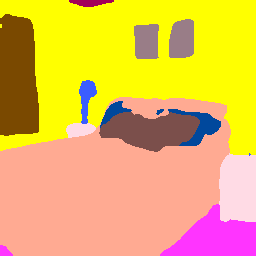

torch.Size([256, 256])


In [15]:
with torch.no_grad():
    seg = segmodel.segment_batch(original.unsqueeze(0))

reload(imgviz)
iv = imgviz.ImageVisualizer(256)
show([[iv.segmentation(seg[0][0])], iv.segment_key(seg[0,0], segmodel)])
mask = (seg[0][0] == 21).float().cpu()
#mask = renormalize.as_url(mask)
print(mask.shape)

In [5]:
dim = 11
blur_kernel = (1/2**(dim))*torch.ones(dim, dim)
blur_kernel = blur_kernel[None, None]
#blur_kernel = blur_kernel.repeat(1, 1, 1, 1).cuda()

# blur_conv = F.conv2d(mask[None, None], blur_kernel, padding=5).squeeze()
# print(blur_conv.shape)
# blur_conv[blur_conv!=0] = 1


In [ ]:
masked_model = make_masked_stylegan(
                gan_model, z, blur_conv)

In [6]:
import numpy as np
import cv2

def get_max_lamp(seg): #gets x,y coordinates of largest lamp
    
    #show(renormalize.as_image(im[0]))

    '''with torch.no_grad():
        lamps = segmodel.predict_single_class(im, 21, downsample=4)'''
    seg = seg.squeeze().int()
    print(seg.shape)
#     seg[seg!=21] = 0 #lamp index in segmentation = 21
#     seg[seg==21] = 1
    
    #binary_lamps = lamps[1]*1
    
    binary_lamps = np.uint8(seg.cpu())
    lamp_centroids = []
    max_lamps = [] 
 
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(binary_lamps, connectivity=8)
    sizes = stats[:, -1]
    
    #print(output)
#     print(nb_components)
#     print(np.unique(output))
#     print(sizes)
    
    if len(np.unique(output))<=1: #no lamps detected
        a = torch.Tensor(np.zeros([seg.shape[1], seg.shape[1]]))
        return a

        

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

    max_lamp = np.zeros(output.shape)
    print('max label', max_label)
    max_lamp[output == max_label] = 1
    #max_lamp = Image.fromarray(max_lamp)
    #max_lamp_layers = [max_lamp.resize([conv_dim, conv_dim], resample=Image.BILINEAR) for conv_dim in conv_dims] # TODO put assertion that it's still binary

#     a = [ndimage.zoom(max_lamp, conv_dim/256) for conv_dim in conv_dims]
#     if i==0: 
#         print(a)

#     #a = np.array([np.array(max_lamp_layer) for max_lamp_layer in max_lamp_layers])
#     #a = np.array(max_lamp_layers)
#     #max_lamp_int = np.uint8(max_lamp)

#     max_lamps.append(a)
    
    return torch.from_numpy(max_lamp)



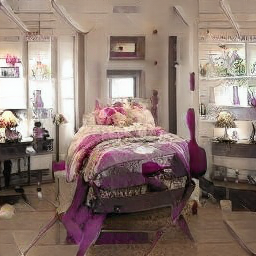
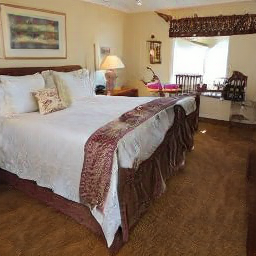
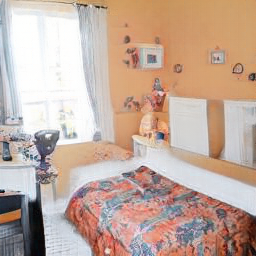
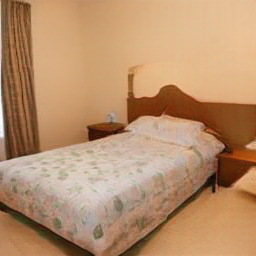
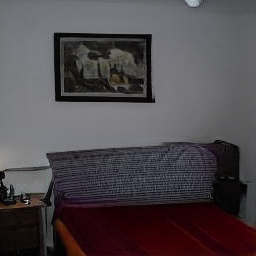
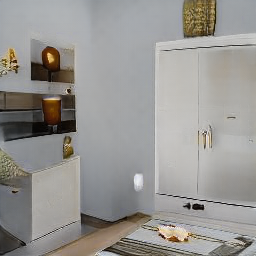
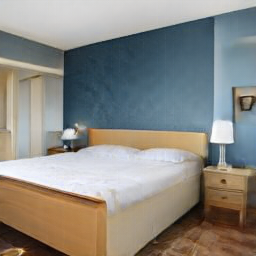
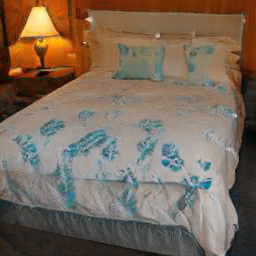
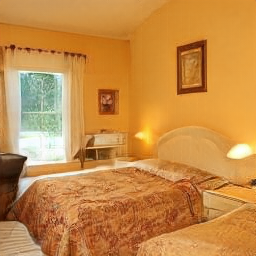
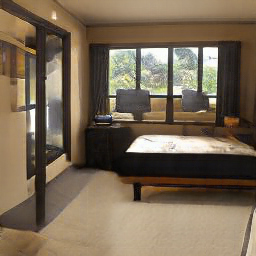
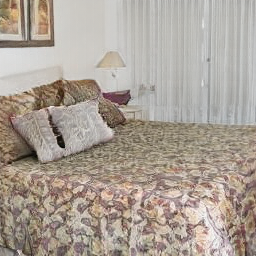
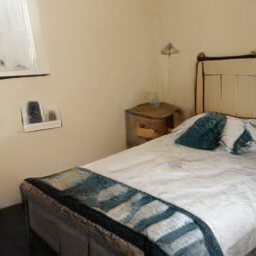
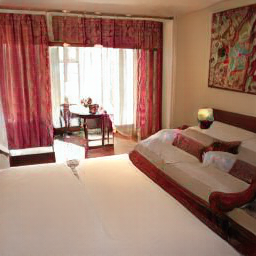
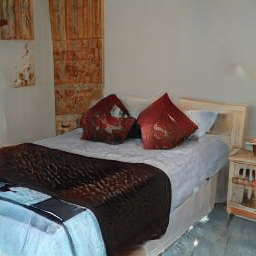
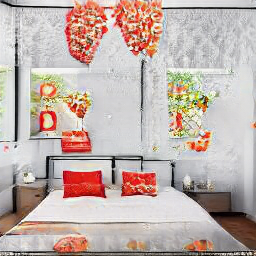
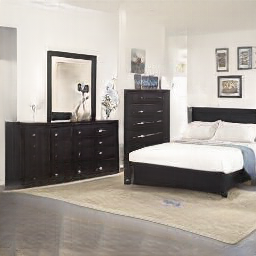
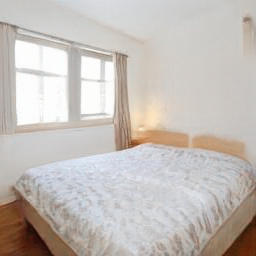
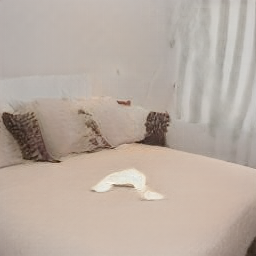
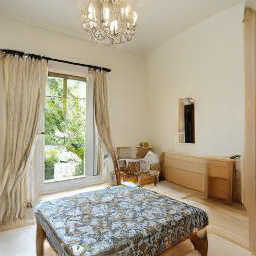
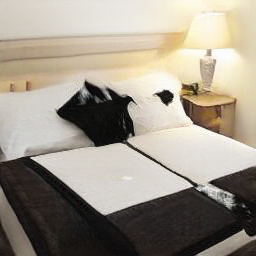
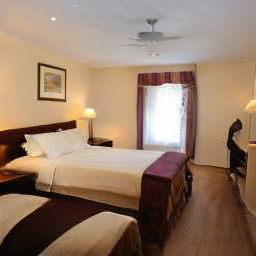
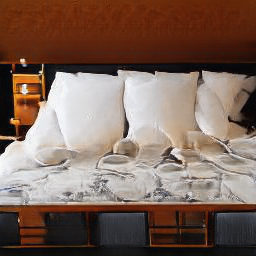
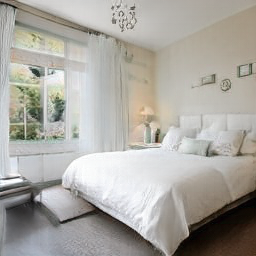
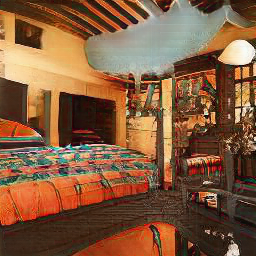
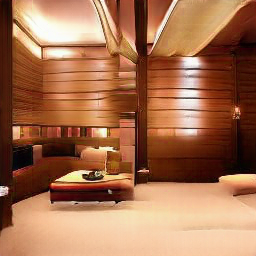

In [27]:
image_numbers = range(25)#  [46] [77] [59] [95]
def pilim(idata):
    return renormalize.as_image(idata)
show([
    [pilim(gan_model(zds[i][0][None].cuda())[0]), i]
    for i in image_numbers])

torch.Size([1, 256, 256])
torch.Size([256, 256])
max label 1


,,

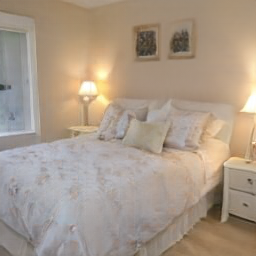
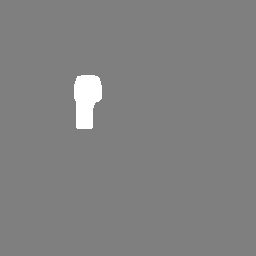
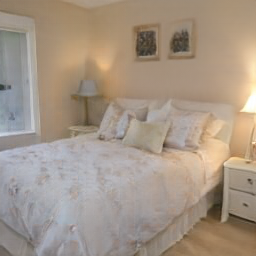

In [13]:
def pilim(idata):
    return renormalize.as_image(idata)
for i in range(41, 42): 
    z = zds[i][0][None].cuda()
    original = gan_model(z)[0]
    with torch.no_grad():
        _, lamps = segmodel.predict_single_class(original[None], 21)
        seg = 1*lamps
        print(seg.shape)
        mask = get_max_lamp(seg).float()
        #print(mask)
        blur_conv = F.conv2d(mask[None, None], blur_kernel, padding=5).squeeze()
        blur_conv[blur_conv!=0] = 1
        
        frac = -10
        masked_model = make_masked_stylegan(
                gan_model, z, blur_conv, frac)
        
        edited = masked_model(z)[0]
    #print(blur_conv)
    #print(frac)
    
    show([(pilim(original), pilim(blur_conv[None].repeat(3, 1, 1)), pilim(edited))])
        
    
    
    

In [12]:
with torch.no_grad():
    _, lamps = segmodel.predict_single_class(original[None], 21)
    lamps = 1*lamps
print(lamps.shape)
print(torch.max(lamps))
print(torch.min(lamps))

torch.Size([1, 256, 256])
tensor(1, device='cuda:0')
tensor(0, device='cuda:0')
